In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

In [3]:
path_to_train = "../TrackML_100_events_dataset/"

In [4]:
event_prefix = "event000001000"

In [5]:
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

In [6]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [9]:
def cartesian_to_cylindrical(x, y, z):
    
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    z = z
    
    return r, phi, z


def create_hough_matrix(hits):
    
    hough_matrix = hits[['hit_id', 'x', 'y', 'z']].copy()
    hough_matrix.columns = ['HitID', 'X', 'Y', 'Z']
    
    r, phi, z = cartesian_to_cylindrical(hough_matrix['X'].values, 
                                         hough_matrix['Y'].values, 
                                         hough_matrix['Z'].values)

    hough_matrix['R'] = r
    hough_matrix['Phi'] = phi
    
    return hough_matrix


def add_theta(hough_matrix, theta):
    hough_matrix['Theta'] = theta
    return hough_matrix

def add_r0_inv(hough_matrix):
    hough_matrix['R0Inv'] = (2. * np.cos(hough_matrix['Phi'] - hough_matrix['Theta']) / hough_matrix['R']).values
    return hough_matrix

def add_gamma(hough_matrix):
    hough_matrix['Gamma'] = hough_matrix['Z']/hough_matrix['R']
    return hough_matrix


def digitize_column(hough_matrix, col, N, min_val=None, max_val=None):
    
    x = hough_matrix[col].values
    if min_val is not None and max_val is not None:
        bins = np.linspace(min_val, max_val, N)
    else:
        bins = np.linspace(x.min(), x.max(), N)
    bin_ids = np.digitize(x, bins)
    hough_matrix[col+'Digi'] = bin_ids
    
    return hough_matrix


def combine_digi(hough_matrix, columns):
    
    hough_matrix['ComboDigi'] = np.zeros(len(hough_matrix))
    
    for i_col, acol in enumerate(columns):
        digi = hough_matrix[acol]
        hough_matrix['ComboDigi'] += digi * 10**(i_col * 5)
    
    return hough_matrix


def count_combo_digi(hough_matrix):
    
    unique, indeces, counts = np.unique(hough_matrix['ComboDigi'].values, 
                                     return_counts=True, return_inverse=True)
    hough_matrix['ComboDigiCounts'] = counts[indeces]
    
    return hough_matrix

def out_of_border_counters_to_zero(hough_matrix, col, N):
    hough_matrix['ComboDigiCounts'] *= (hough_matrix[col].values != 0) * (hough_matrix[col].values != N)
    return hough_matrix

#def plot_hough_space(hough_matrix_ab):
    #plt.figure(figsize=(12,8))
    #plt.imshow(hough_matrix_ab[], interpolation='none', origin='lower')
    #plt.title("Hough Transform", size=25)
    #plt.xlabel("Theta, bin ids", size=25)
    #plt.ylabel("1 / r0, bin ids", size=25)
    #plt.colorbar()
    #plt.show()

def one_slice(hough_matrix, theta, N_bins_r0inv, N_bins_gamma, min_hits):
        
    tracks = []
    
    hough_matrix = add_theta(hough_matrix, theta)
    hough_matrix = add_r0_inv(hough_matrix)
    hough_matrix = add_gamma(hough_matrix)

    hough_matrix = digitize_column(hough_matrix, 'R0Inv', N_bins_r0inv, -0.02, 0.02) # Tune it.
    hough_matrix = digitize_column(hough_matrix, 'Gamma', N_bins_gamma, -50, 50) # Tune it.
    
    hough_matrix = combine_digi(hough_matrix, ['R0InvDigi', 'GammaDigi'])
    hough_matrix = count_combo_digi(hough_matrix)

    hough_matrix = out_of_border_counters_to_zero(hough_matrix, 'R0InvDigi', N_bins_r0inv)
    hough_matrix = out_of_border_counters_to_zero(hough_matrix, 'GammaDigi', N_bins_gamma)
    
    #plot_hough_space(hough_matrix['Gamma'].values,hough_space['R0Inv'].values)
    counts = hough_matrix.ComboDigiCounts.values
    bins = hough_matrix.ComboDigi.values
    hit_ids = np.arange(len(hough_matrix))
    for abin in np.unique(bins[counts >= min_hits]):
        atrack = hit_ids[(bins == abin)]
        tracks.append(atrack)
        
    return tracks, hough_matrix




class Clusterer(object):
    
    def __init__(self, N_bins_r0inv, N_bins_gamma, N_theta, min_hits):
        
        self.N_bins_r0inv = N_bins_r0inv 
        self.N_bins_gamma = N_bins_gamma
        self.N_theta = N_theta
        self.min_hits = min_hits
    
    def predict(self, hits):
        
        tracks = []

        hough_matrix = create_hough_matrix(hits)
        
        for theta in np.linspace(-np.pi, np.pi, self.N_theta):
            slice_tracks, hough_matrix = one_slice(hough_matrix, theta, self.N_bins_r0inv, self.N_bins_gamma, self.min_hits)
            tracks += list(slice_tracks)
        #hough_matrix.head()
        #hough_matrix_ab=hough_matrix.to_numpy()
        #print(hough_matrix_ab)
        #plot_hough_space(hough_matrix_ab)
        print(tracks)
        plt.figure(figsize=(5,5))
        plt.scatter(hough_matrix['R0Inv'].values,hough_matrix['Gamma'].values, s=1)
        plt.title("Hough Space", size=25)
        plt.xlabel("Theta, bin ids", size=25)
        plt.ylabel("1 / r0, bin ids", size=25)
        #plt.colorbar()
        plt.show()
        labels = np.zeros(len(hits))
        used = np.zeros(len(hits))
        track_id = 0
        for atrack in tracks:
            u_track = atrack[used[atrack] == 0]
            if len(u_track) >= self.min_hits:
                labels[u_track] = track_id
                used[u_track] = 1
                track_id += 1
                
        plt.figure(figsize=(20,20))
        plt.scatter(hough_matrix['X'].values, hough_matrix['Y'].values, s=0.4)

        for lab in np.unique(labels[labels != -1]):
            xs = hough_matrix['X'].values[labels == lab]#event.x.values[labels == lab]
            ys = hough_matrix['Y'].values[labels == lab]#event.y.values[labels == lab]    
            sort_inds = xs.argsort()    
            plt.plot(xs[sort_inds], ys[sort_inds], linewidth=0.1)

        plt.title("Hits and Reconstructed Tracks", size=15)
        plt.xlabel("x", size=25)
        plt.ylabel("y", size=25)
        plt.grid(b=1)
        plt.show()
        
        return labels

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



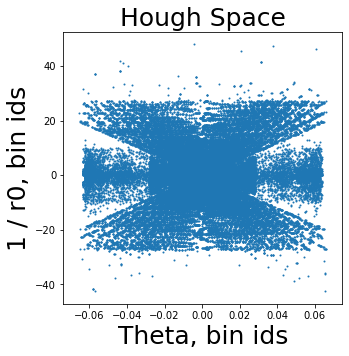

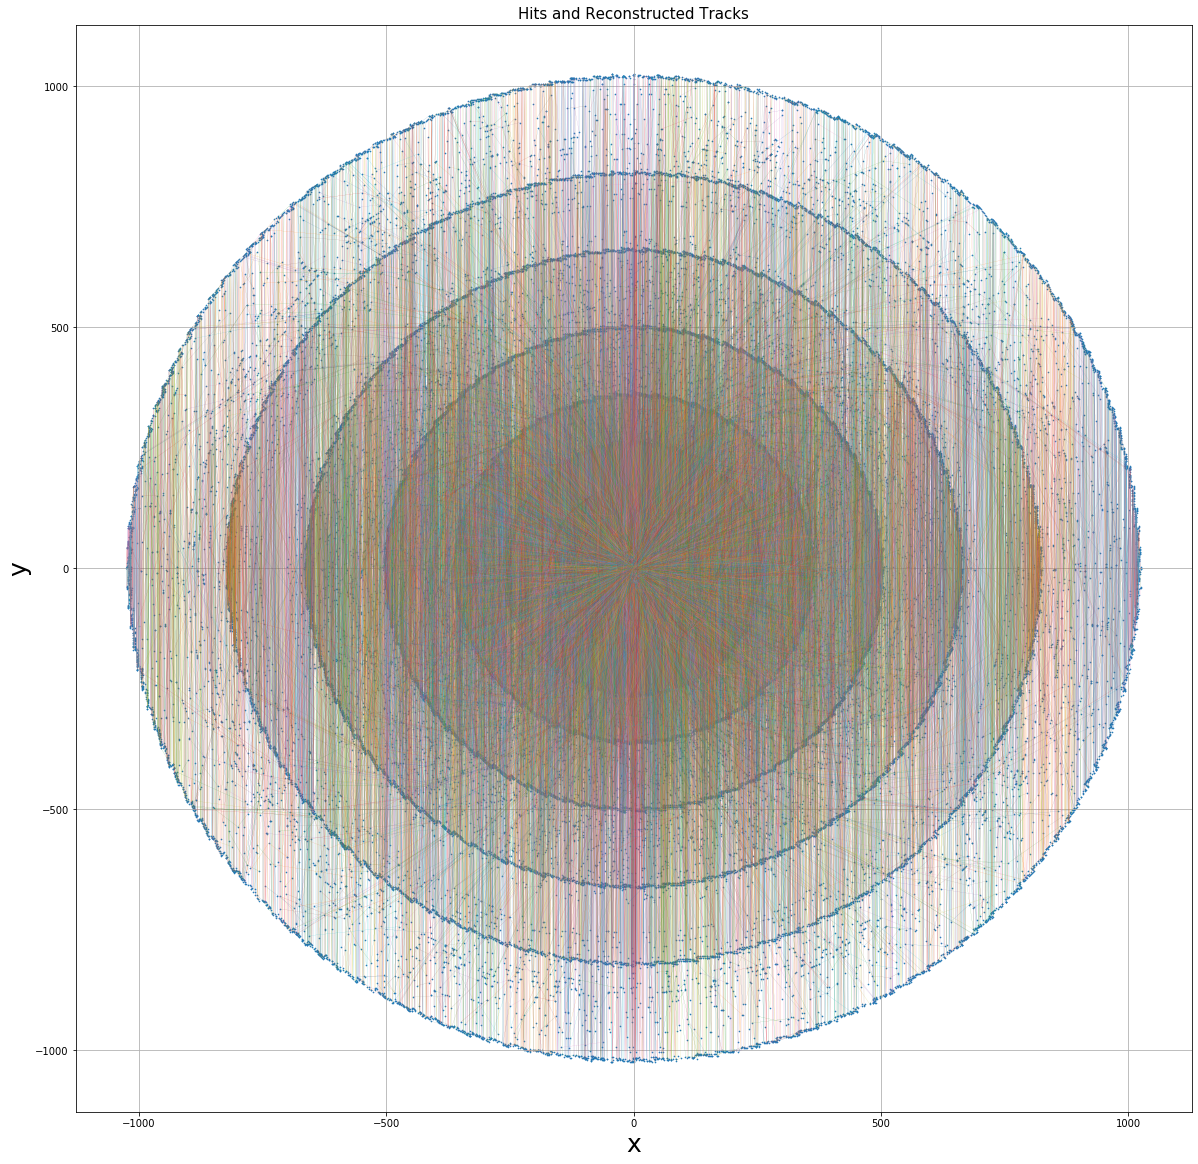

[   0. 5539.    0. ... 2084. 2124. 2124.]
CPU times: user 2min 25s, sys: 2.33 s, total: 2min 28s
Wall time: 2min 25s


In [10]:
%%time
# Warning: it takes about 100s per one event.

model = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=9)
labels = model.predict(hits)
print(labels)

### Create Submission

In [12]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [13]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [14]:
print("Your score: ", score)

Your score:  0.1403401478160794


In [18]:
 load_dataset(path_to_train, skip=1000, nevents=5)

<generator object load_dataset at 0x12b17aa50>

In [21]:
dataset_submissions = []
dataset_scores = []

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=1000, nevents=5):
        
    # Track pattern recognition
    model = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=9)
    labels = model.predict(hits)
        
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)
    
    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)
    
    print("Score for event %d: %.3f" % (event_id, score))
    
print('Mean score: %.3f' % (np.mean(dataset_scores)))

Mean score: nan


In [22]:
path_to_test = "../input/test"
test_dataset_submissions = []

create_submission = False # True for submission 

if create_submission:
    for event_id, hits, cells in load_dataset(path_to_test, parts=['hits', 'cells']):

        # Track pattern recognition
        model = Clusterer(N_bins_r0inv=200, N_bins_gamma=500, N_theta=500, min_hits=9)
        labels = model.predict(hits)

        # Prepare submission for an event
        one_submission = create_one_event_submission(event_id, hits, labels)
        test_dataset_submissions.append(one_submission)
        
        print('Event ID: ', event_id)

    # Create submission file
    submission = pd.concat(test_dataset_submissions, axis=0)
    submission.to_csv('submission.csv.gz', index=False, compression='gzip')